# Laplace Noise Experiment
This notebook contains the code required to run the experiment that shows that our algorithm can still perform even when given Laplacian noise. 

In [1]:
import sys 
sys.path.append('..')
import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform, Laplace
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 
import IPython

from delphi.stats.linear_regression import TruncatedRegression
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata

TABLE_NAME = 'logs'

# commands and arguments
COMMAND = 'Rscript'
PATH2SCRIPT = './truncreg.R'
TMP_FILE = 'tmp.csv'
RESULT_FILE = 'result.csv'

In [86]:
args = Parameters({
    "bias": True,
    "samples": 10000,
    "c": 0,
    "batch_size": 100,
    "lr": 1e-1,
    "var_lr": 1e-1,
    "var_": 1,
    "trials": 3,
    "norm": False,
    "workers": 8,
    "steps": 2500,
    "x_lower": -10,
    "x_upper": 10,
    'lower': -1, 
    'upper': 1,
    "lower": -1,
    "upper": 1,
#     'out_dir': '<PROVIDE OUT DIRECTORY FOR EXPERIMENT LOGS HERE>',
    'out_dir': '/Users/patroklos/Desktop/10D_Laplace_/',
    'val': .1, 
    'n': 100,
    'tol': 1e-1,
#     'exp': '<PROVIDE EXPERIMENT NAME HERE>'
    'exp': 'laplace'
})
mse_loss = ch.nn.MSELoss()

I will start by generating the ground-truth for a simple example experiment. For this experiment, we will sample our input features from a $N(0, I)$, our ground-truth parameters from a $Unif(-1, 1)$, and our noise from a Laplace distribution with variance 5.

gt weight:  Parameter containing:
tensor([[0.0287]], requires_grad=True)
gt bias:  Parameter containing:
tensor([[0.9637]], requires_grad=True)
alpha:  tensor([0.8722])
gt ols coef:  [[0.02379168]]
gt ols intercept:  [0.9692237]
trunc ols coef:  [[0.01290592]]
trunc ols intercept:  [1.2164546]


Text(0, 0.5, 'y')

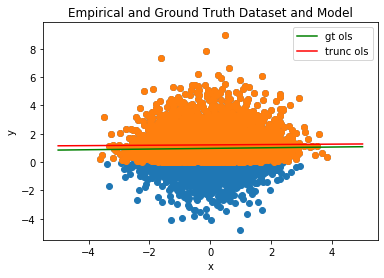

In [87]:
# distribution for generating feature vectors
d, k = 1, 1
w = Uniform(args.lower, args.upper)
m = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
phi = oracle.Left(Tensor([0.0]))

# generate ground truth
gt = ch.nn.Linear(in_features=k, out_features=1)
gt.weight = ch.nn.Parameter(w.sample(ch.Size([k, d])))

# gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
gt.bias = ch.nn.Parameter(w.sample(ch.Size([1, 1]))) if args.bias else None

print("gt weight: ", gt.weight)
print("gt bias: ", gt.bias)

# create base classifier
with ch.no_grad():
    # generate data
    X = m.sample(ch.Size([args.samples, d])) if isinstance(m, Uniform) else m.sample(ch.Size([args.samples]))
    y = gt(X)

noise_var = ch.ones(1)
noise_scale = ch.sqrt(noise_var/2)
laplace = Laplace(ch.zeros(1), noise_scale)
# remove synthetic data from the computation graph
with ch.no_grad():
    # add noise to ground-truth pedictions
    noised = y + laplace.sample(ch.Size([X.size(0)]))
    # truncate based off of the standardized data
    indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = noised[indices], X[indices]
    alpha = Tensor([y_trunc.size(0) / args.samples])
    print("alpha: ", alpha)
    
# ground-truth OLS
gt_ols = LinearRegression()
gt_ols.fit(X, noised)
print("gt ols coef: ", gt_ols.coef_)
print("gt ols intercept: ", gt_ols.intercept_)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
trunc_ols_pred = trunc_ols.predict(x_trunc)
print("trunc ols coef: ", trunc_ols.coef_)
print("trunc ols intercept: ", trunc_ols.intercept_)

# data for plotting regressions
unnorm_data = np.linspace(-5, 5, 100).reshape(100, 1)
norm_data = np.linspace(-1, 1, 100).reshape(100, 1)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt ols')
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Empirical and Ground Truth Dataset and Model")
ax.set_xlabel("x")
ax.set_ylabel("y")

Now, we want to normalize our input features dataset. So, we divide all of our covariate features by $B\sqrt{k}$, so that $||x_{i}||_{2}^{2} \leq 1$, and reside on the $\ell_{2}$ ball. By doing this, the norm of $w$ will be multiplied by $B\sqrt{k}$.

In [88]:
max_x_trunc_norm = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
print("max truncated x norm", max_x_trunc_norm)

beta = max_x_trunc_norm*math.sqrt(X.size(1))
print("beta: ", beta)

x_trunc_norm = x_trunc / beta
print("x max l2: ", x_trunc_norm.norm(dim=-1).max())

max truncated x norm tensor(3.8196)
beta:  tensor(3.8196)
x max l2:  tensor(1.)


We now observe that the norm of the truncated x covariates is bounded by 1. 

Now, we will standardze our dependent variable so that it's ground-truth takes the form of the linear regression latent variable model with noise variance of 1.

First, we will standardize our data for the case where we assume that the empirical noise variance is the underlying noise variance of the ground truth regression.

emp noise var:  tensor([0.6474])
trunc reg noise var:  tensor([1.0000])


Text(0, 0.5, 'y')

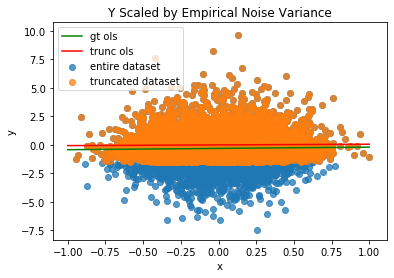

In [89]:
emp_noise_var = (y_trunc - trunc_ols_pred).var(0)
print("emp noise var: ", emp_noise_var)

emp_stand_y_trunc = (y_trunc - trunc_ols.intercept_) / ch.sqrt(emp_noise_var)
trunc_noise_var = (emp_stand_y_trunc - (trunc_ols_pred / ch.sqrt(emp_noise_var))).var(0)
print("trunc reg noise var: ", trunc_noise_var)

new_X, emp_stand_noised = X / beta, (noised - trunc_ols.intercept_) / ch.sqrt(emp_noise_var)

gt_emp_stand = LinearRegression()
gt_emp_stand.fit(new_X, emp_stand_noised)

trunc_emp_stand_ols = LinearRegression()
trunc_emp_stand_ols.fit(x_trunc_norm, emp_stand_y_trunc)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title('Y Scaled by Empirical Noise Variance')
ax.set_xlabel("x")
ax.set_ylabel("y")

Now, we will standardize our data for the case where we assume that we know the underlying ground-truth noise variance.

trunc reg noise var:  tensor([0.6474])
reg noise var:  tensor([1.0441])


Text(0, 0.5, 'y')

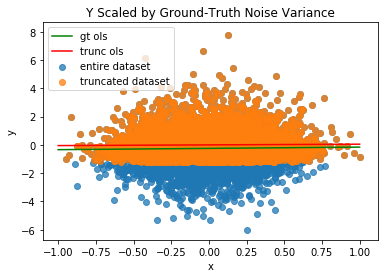

In [90]:
stand_noised, stand_y_trunc = (noised - trunc_ols.intercept_) / ch.sqrt(noise_var), (y_trunc - trunc_ols.intercept_) / ch.sqrt(noise_var)

gt_stand = LinearRegression()
gt_stand.fit(new_X, stand_noised)

trunc_stand_ols = LinearRegression()
trunc_stand_ols.fit(x_trunc_norm, stand_y_trunc)

trunc_noise_var = (stand_y_trunc - trunc_stand_ols.predict(x_trunc_norm)).var(0)
print("trunc reg noise var: ", trunc_noise_var)

reg_noise_var = (stand_noised - gt_stand.predict(new_X)).var(0)
print("reg noise var: ", reg_noise_var)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Y Scaled by Ground-Truth Noise Variance")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Empirical Variance

In [91]:
emp_scale_phi = oracle.Left((phi.left - trunc_ols.intercept_) / ch.sqrt(emp_noise_var))
known_emp_trunc_reg = TruncatedRegression(phi=emp_scale_phi, alpha=alpha, unknown=False, val=int(args.val*x_trunc.size(0)), bs=args.bs, n=args.n, tol=args.tol, steps=args.steps)
known_emp_trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)

known_emp_w_unnorm = (known_emp_trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta
known_emp_bias_unnorm = known_emp_trunc_reg.intercept * ch.sqrt(emp_noise_var) + trunc_ols.intercept_

Iteration 1 | Score: 0.3195285201072693
Final Score: 0.004197106231004


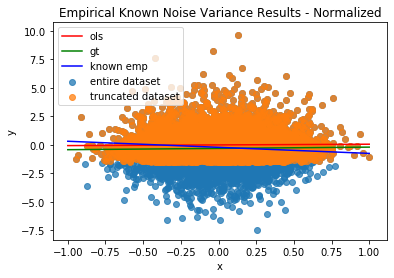

Text(0, 0.5, 'y')

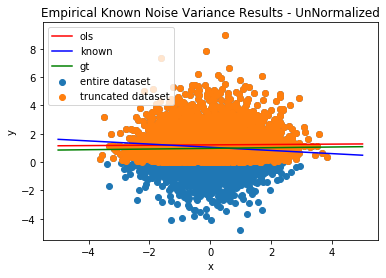

In [92]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_emp_trunc_reg(Tensor(norm_data)).detach().numpy(), label='known emp', color='blue')
plt.legend()
plt.title("Empirical Known Noise Variance Results - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='ols')

plt.plot(unnorm_data, (Tensor(unnorm_data)@known_emp_w_unnorm + known_emp_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.scatter(X, noised, label='entire dataset')
plt.scatter(x_trunc, y_trunc, label='truncated dataset')
plt.legend()
plt.title("Empirical Known Noise Variance Results - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")

We now run our procedure for truncated regression with known variance, assuming that we are given the ground-truth noise variance.

In [93]:
stand_phi = oracle.Left((phi.left - trunc_ols.intercept_) / ch.sqrt(noise_var))
known_trunc_reg = TruncatedRegression(phi=stand_phi, alpha=alpha, unknown=False, val=int(args.val*x_trunc.size(0)), bs=args.bs, n=args.n, tol=args.tol, steps=args.steps)
known_trunc_reg.fit(x_trunc_norm, stand_y_trunc)

known_weight_unnorm = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta
known_bias_unnorm = known_trunc_reg.intercept * ch.sqrt(noise_var) + trunc_ols.intercept_

Iteration 1 | Score: 0.19749075174331665
Iteration 2 | Score: 0.19409403204917908
Final Score: 0.08574823290109634


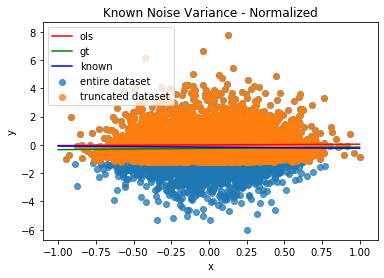

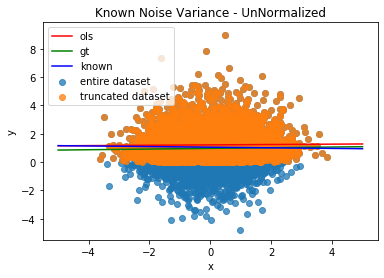

In [94]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_trunc_reg(Tensor(norm_data)).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='r', label='ols')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_weight_unnorm + known_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Truncated Regression with Unknown Noise Variance

In [95]:
unknown_trunc_reg = TruncatedRegression(phi=emp_scale_phi, alpha=alpha, unknown=True, val=int(args.val*x_trunc.size(0)), bs=args.bs, n=args.n, tol=args.tol, steps=args.steps)
unknown_trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)

unknown_weight_unnorm = (unknown_trunc_reg.weight  * ch.sqrt(emp_noise_var)) / beta
unknown_bias_unnorm = unknown_trunc_reg.intercept * ch.sqrt(emp_noise_var) + trunc_ols.intercept_

Iteration 1 | Score: 0.6243842840194702
Iteration 2 | Score: 0.19554847478866577
Iteration 3 | Score: 0.18319804966449738
Iteration 4 | Score: 0.252828449010849
Iteration 5 | Score: 0.18312200903892517
Iteration 6 | Score: 0.7254888415336609
Iteration 7 | Score: 0.25011715292930603
Iteration 8 | Score: 0.18426653742790222
Iteration 9 | Score: 0.1519801914691925
Iteration 10 | Score: 0.19379448890686035
Iteration 11 | Score: 0.28654536604881287
Iteration 12 | Score: 0.13796445727348328
Iteration 13 | Score: 0.1536390483379364
Iteration 14 | Score: 0.2598540484905243
Iteration 15 | Score: 0.10361170023679733
Iteration 16 | Score: 0.1366616040468216
Iteration 17 | Score: 0.14776529371738434
Iteration 18 | Score: 0.12910248339176178
Iteration 19 | Score: 0.13172094523906708
Iteration 20 | Score: 0.15001577138900757
Iteration 21 | Score: 0.14583177864551544
Iteration 22 | Score: 0.14712363481521606
Iteration 23 | Score: 0.17167209088802338
Iteration 24 | Score: 0.1747211068868637
Iteration 

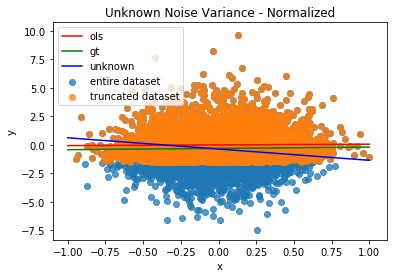

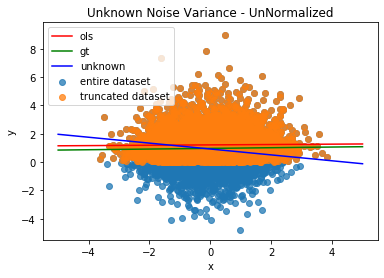

In [96]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, unknown_trunc_reg(Tensor(norm_data)).detach().numpy(), label='unknown', color='blue')
plt.legend()
ax.set_title("Unknown Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), label='ols', color='red')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='g', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@unknown_weight_unnorm + unknown_bias_unnorm), color='blue', label='unknown')
plt.legend()
ax.set_title("Unknown Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Add Laplace Noise and Truncate at Various Parameters C

In [97]:
def run_trial(kwargs, X, y):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > 3e-1) and attempt < 3:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time    

In [98]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 10, 1

# distribution for generating feature vectors
W = Uniform(w_lower, w_upper)
dist = Uniform(-5, 5)
noise_var = 10*ch.ones(1)
noise_scale = ch.sqrt(noise_var/2)
laplace = Laplace(ch.zeros(1), noise_scale)

# C = [-2.5, -2, -1.75, -1.5, -1.25, -1.0, -.75, -.5, -.25, 0.0, .25, .5, .75, 1.0]

C = [-2.5, -2, -1.75, -1.5, -1.25, -1.0]


# generate ground truth
gt = ch.nn.Linear(in_features=d, out_features=k)
gt.weight = ch.nn.Parameter(W.sample(ch.Size([k, d])))
gt.bias = ch.nn.Parameter(W.sample(ch.Size([1, 1]))) if args.bias else None

# create base classifier
with ch.no_grad():
    # generate data
    X = dist.sample(ch.Size([args.samples, d])) if isinstance(dist, Uniform) else dist.sample(ch.Size([args.samples]))
    y = gt(X)

for i in range(args.trials):
    # create store and add table
    store = Store(args.out_dir + args.exp)
    store.add_table(TABLE_NAME, { 
        'ols_r2': float,
        'ols_param_mse': float,
        'ols_var_l1': float,
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_r2': float, 
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_time': int,
        'trunc_reg_r2': float,
        'trunc_reg_param_mse': float, 
        'trunc_reg_var_mse': float,
        'trunc_reg_time': int,
        'alpha': float, 
        'c': float,
        'num_samples': int,
        'noise_var': float, 
    })
    
    # add laplace noise to linear regression
    noised = y + laplace.sample(ch.Size([X.size(0)]))
        
    # iterate over truncation parameter C
    for c in C: 
        phi = oracle.Left(c)
        # add noise to ground-truth pedictions
        # truncate based off of the standardized data
        indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = noised[indices], X[indices]
        alpha = Tensor([y_trunc.size(0) / args.samples])
        
        val = int(args.val*x_trunc.size(0))
        
        # normalize x features so that ||x_{i}||_{2}^{2} <= 1
        l_inf = LA.norm(x_trunc, dim=-1, ord=float('inf')).max() # find max l_inf
        # calculate normalizing constant
        beta = l_inf*math.sqrt(d)
        """
        Divide input features by normalizing constant. By doing so, 
        the weights will be increased by a magnitude of beta.
        """
        x_trunc_norm = x_trunc / beta
         # normalize entire dataset by beta
        x_norm = X / beta
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - noise_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })

        
        """
        Run dataset on truncated regression with known variance. This means that we want to standardize 
        our dependent variable by the true noise variance. 
        """
        # standardize y trunc by the empirical noise variance
        stand_y_trunc = y_trunc / ch.sqrt(noise_var)
        # standardize noised by the empirical noise variance
        known_kwargs = { 
            'phi': oracle.Left(c/ch.sqrt(noise_var)), 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        
        known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, stand_y_trunc)
        w, w0 = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta, known_trunc_reg.intercept[..., None] * ch.sqrt(noise_var)
        known_params = ch.cat([w, w0]).flatten()

        # known results
        store[TABLE_NAME].update_row({
            'known_r2': r2_score(noised.flatten(), X@w + w0), 
            'known_param_mse': mse_loss(known_params, gt_params),
            'known_time': total_time, 
        })
        

        """
        Run dataset on truncated regression with known variance, while 
        assuming that the empirical noise variance is the underlying noise 
        variance of our linear regression. This means that we want to standardize 
        our dependent variable by the empirical noise variance. 
        """
        # variance of the residuals
        emp_noise_var = (y_trunc - ols.predict(x_trunc)).var(0)
        # standardize y trunc by the empirical noise variance
        emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)
        
        # truncated regression with unknown variance
        unknown_kwargs = { 
            'phi': oracle.Left(c/ch.sqrt(emp_noise_var)), 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        
        unknown_trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, emp_stand_y_trunc)
        w, w0 = (unknown_trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta, unknown_trunc_reg.intercept * ch.sqrt(emp_noise_var)
        unknown_params = ch.cat([w, w0]).flatten()

        # unknown results
        store[TABLE_NAME].update_row({
            'unknown_r2': r2_score(noised.flatten(), X@w + w0), 
            'unknown_param_mse': mse_loss(unknown_params, gt_params),
            'unknown_var_l1': float(ch.abs(unknown_trunc_reg.variance * emp_noise_var - noise_var)),
            'unknown_time': total_time, 
        })
        
            
        # spawn subprocess to run truncreg experiment
        concat = ch.cat([x_trunc, y_trunc], dim=1).numpy()
        """
        DATA FORMAT:
            -First n-1 columns are independent variables
            -nth column is dependent variable
        """
        concat_df = pd.DataFrame(concat)
        concat_df.to_csv(args.out_dir + TMP_FILE) # save data to csv
        """
        Arguments
        - c - truncation point (float)
        - dir - left or right -> type of truncation (str)
        """
        cmd = [COMMAND, PATH2SCRIPT] + [str(c), str(d), 'left', args.out_dir]

        # check_output will run the command and store the result
        st = datetime.datetime.now()
        result = subprocess.check_output(cmd, universal_newlines=True)
        trunc_res = Tensor(pd.read_csv(args.out_dir + RESULT_FILE)['x'].to_numpy())
        trunc_reg_params = ch.cat([trunc_res[1:-1].flatten(), trunc_res[0][None,...]])

        trunc_reg_pred = X@trunc_reg_params[:-1] + trunc_reg_params[-1]
        
        # truncreg results
        store[TABLE_NAME].update_row({
            'trunc_reg_r2': r2_score(noised.flatten(), trunc_reg_pred.flatten()), 
            'trunc_reg_param_mse': mse_loss(trunc_reg_params, gt_params),
            'trunc_reg_var_mse': ch.abs(trunc_res[-1].pow(2)[None,...] - noise_var),
            'trunc_reg_time': int((datetime.datetime.now() - st).total_seconds()), 
            })
        
        # add additional exp data to store
        store[TABLE_NAME].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_var': float(noise_var), 
            'c': c,
        })
        IPython.display.clear_output()
        
        # append row to table
        store[TABLE_NAME].flush_row()
    store.close()    

In [73]:
reader = CollectionReader(args.out_dir + args.exp)
logs = reader.df(TABLE_NAME)
reader.close()
logs.head()

100%|██████████| 3/3 [00:00<00:00, 58.12it/s]


,ols_r2,ols_param_mse,ols_var_l1,known_r2,known_param_mse,known_time,unknown_r2,unknown_param_mse,unknown_var_l1,unknown_time,trunc_reg_r2,trunc_reg_param_mse,trunc_reg_var_mse,trunc_reg_time,alpha,c,num_samples,noise_var,exp_id
0,0.745024,0.196322,2.115086,0.787916,0.013711,0,0.787753,0.011833,2.769155,4,0.806288,0.003041,0.195887,1,0.6196,-2.50,6196,10.0,ea75308c-af2d-41e8-83cd-1c1a719b0d8f
1,0.732323,0.239871,2.170811,0.780039,0.081047,0,0.766847,0.077725,3.066242,9,0.806382,0.002952,0.153974,2,0.5917,-2.00,5917,10.0,ea75308c-af2d-41e8-83cd-1c1a719b0d8f
2,0.726685,0.259091,2.163830,0.783467,0.036426,0,0.785382,0.027138,2.749051,17,0.805691,0.005019,0.031708,1,0.5797,-1.75,5797,10.0,ea75308c-af2d-41e8-83cd-1c1a719b0d8f
3,0.720092,0.282087,2.175562,0.754828,0.128476,0,0.802813,0.003379,2.600147,16,0.805212,0.006630,0.035501,2,0.5669,-1.50,5669,10.0,ea75308c-af2d-41e8-83cd-1c1a719b0d8f
4,0.712412,0.308958,2.211849,0.771946,0.063223,0,0.692357,0.104051,2.552564,8,0.804562,0.008447,0.071472,1,0.5541,-1.25,5541,10.0,ea75308c-af2d-41e8-83cd-1c1a719b0d8f


In [74]:
cols = ['unknown_param_mse', 'unknown_var_l1', 'c', 'alpha']
unknown_logs = pd.DataFrame(columns=cols)
for c in C: 
    temp = logs[logs['c'] == c][cols].reset_index()
#     temp.drop(index=temp[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmax(), inplace=True)
#     temp.drop(index=temp[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmin(), inplace=True)
#     temp.drop(['index'], axis=1, inplace=True)
    unknown_logs = pd.concat([unknown_logs, temp])
unknown_logs = unknown_logs.reset_index()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [75]:
cols = ['known_param_mse', 'c', 'alpha']
known_logs = pd.DataFrame(columns=cols)
for c in C: 
    temp = logs[logs['c'] == c][cols].reset_index()
    temp.drop(index=temp[['known_param_mse']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['known_param_mse']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    known_logs = pd.concat([known_logs, temp])
known_logs = known_logs.reset_index()

In [76]:
cols = ['ols_param_mse', 'ols_var_l1', 'c', 'alpha']
ols_logs = pd.DataFrame(columns=cols)
for c in C: 
    temp = logs[logs['c'] == c][cols].reset_index()
#     temp.drop(index=temp[['ols_param_mse', 'ols_var_l1']].sum(1).idxmax(), inplace=True)
#     temp.drop(index=temp[['ols_param_mse', 'ols_var_l1']].sum(1).idxmin(), inplace=True)
#     temp.drop(['index'], axis=1, inplace=True)
    ols_logs = pd.concat([ols_logs, temp])
ols_logs = ols_logs.reset_index()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


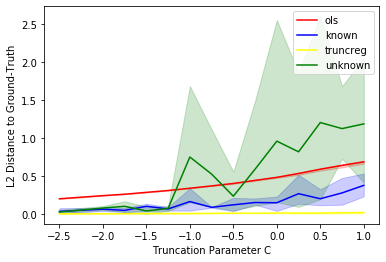

In [77]:
sns.lineplot(data=logs, x='c', y='ols_param_mse', label='ols', color='red')
sns.lineplot(data=logs, x='c', y='known_param_mse', label='known', color='blue')
sns.lineplot(data=logs, x='c', y='trunc_reg_param_mse', color='yellow', label='truncreg')
ax = sns.lineplot(data=logs, x='c', y='unknown_param_mse', label='unknown', color='green')

ax.set(xlabel='Truncation Parameter C', ylabel='L2 Distance to Ground-Truth')
plt.show()

In [85]:
logs[logs.c == -1.0].alpha

5    0.5385
5    0.5457
5    0.5447
Name: alpha, dtype: float64